![](images/pumping_new.jpg)

# Title of the Analysis

**Authors:** Victor Chen, Aaron Cherry 

## Overview

With this analysis, we aim to predict the condition of waterwells in Tanzania based on data retreived from the Taarifa waterpoints dashboard. The dashboard aggregates information collected from the Tanzania Ministry of Water.

## Business Problem

A major challange of the Tanzanian Ministry of Water is determining when, where and how often a water well in Tanzania would need repairs. Implementation of models to predict the condition of a water well would greatly enhance maintenance operations, provide crucial updates associated with the conditions of the water wells and ensure that clean water sources can be provided to the communities in Tanzania. Through this analysis, we aim to provide prediction models based on the information collected to determine water well conditions to aid the Tanzanian Ministry of Water.

## Data Understanding

The data used for this analysis is taken from the Taarifa waterpoints dashboard that functions to aggregate weter well data collected from the Tanzania Ministry of Water. A link to the data and explanation of the features found in the data can be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/). A link to the Taarifa waterpoints dashboard website can be found [here](https://taarifa.org/). The link to the website for the Tanzania Ministry of Water can be found [here](https://www.maji.go.tz/).

The following table is a description of the features in the data along with descriptions of the features.


|**Feature**|**Description**|
|:----------|:------------|
|```amount_tsh``` | Total static head (amount water available to waterpoint)|
|```date_recorded``` | The date the row was entered|
|```funder``` | Who funded the well|
|```gps_height``` | Altitude of the well|
|```installer``` | Organization that installed the well|
|```longitude``` | GPS coordinate|
|```latitude``` | GPS coordinate|
|```wpt_name``` | Name of the waterpoint if there is one|
|```num_private``` | Unknown|
|```basin``` | Geographic water basin|
|```subvillage``` | Geographic location|
|```region``` | Geographic location|
|```region_code``` | Geographic location (coded)|
|```district_code``` | Geographic location (coded)|
|```lga``` | Geographic location|
|```ward``` | Geographic location|
|```population``` | Population around the well|
|```public_meeting``` | True/False|
|```recorded_by``` | Group entering this row of data|
|```scheme_management``` | Who operates the waterpoint|
|```scheme_name``` | Who operates the waterpoint|
|```permit``` | If the waterpoint is permitted|
|```construction_year``` | Year the waterpoint was constructed|
|```extraction_type``` | The kind of extraction the waterpoint uses|
|```extraction_type_group``` | The kind of extraction the waterpoint uses|
|```extraction_type_class``` | The kind of extraction the waterpoint uses|
|```management``` | How the waterpoint is managed|
|```management_group``` | How the waterpoint is managed|
|```payment``` | What the water costs|
|```payment_type``` | What the water costs|
|```water_quality``` | The quality of the water|
|```quality_group``` | The quality of the water|
|```quantity``` | The quantity of water|
|```quantity_group``` | The quantity of water|
|```source``` | The source of the water|
|```source_type``` | The source of the water|
|```source_class``` | The source of the water|
|```waterpoint_type``` | The kind of waterpoint|
|```waterpoint_type_group``` | The kind of waterpoint|

The target class in the data set is ```status_group``` and consists of three classes. The classes and their descriptions can be fouind in the table below:

|Label|Description|
|:-----|:------|
|```functional``` | the waterpoint is operational and there are no repairs needed|
|```functional needs repair``` | the waterpoint is operational, but needs repairs|
|```non functional``` | the waterpoint is not operational|

### Importing Packages and Loading the Datasets

In [1]:
#Import standard packages for data engineering and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, datetime

#import packages to support geo visuals
import folium
from folium.plugins import HeatMap
import json

#Import packages to perform linear regression modeling and preprocessing tools
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, plot_roc_curve, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier
#Import local functions from src/
import sys
sys.path.insert(0, 'src/')

#Ignore warnings in cells
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [104]:
# Import all related data sets
X = pd.read_csv('data/water_well_training_values.csv')
y = pd.read_csv('data/water_well_training_labels.csv')
df = pd.merge(y,X)

In [105]:
# Initial review of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [106]:
#check for duplicates in the data
df[df.duplicated()]

Empty DataFrame
Columns: [id, status_group, amount_tsh, date_recorded, funder, gps_height, installer, longitude, latitude, wpt_name, num_private, basin, subvillage, region, region_code, district_code, lga, ward, population, public_meeting, recorded_by, scheme_management, scheme_name, permit, construction_year, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, quantity_group, source, source_type, source_class, waterpoint_type, waterpoint_type_group]
Index: []

## Data Preparation

- There are some features that have missing data. The first order of business will be to fill or drop these NaN values.
- There are no duplicate data points in the dataset
- There are some features that have data types that don't match with the feature description. These will be converted to the appropriate data type.
- There are some features that will have no significance in determining the classification.

### Dealing with missing values 

In [107]:
# Confirm the columns with missing values
df.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

### - Funder

- The ```funder``` column gives the funding organization for the construction of the well. It is assumed that the well points that do not have an explicit funding source were not funded by a major organization and will be labeled ```other```.

In [108]:
# Fill NaN values according to appropriate method
df['funder'].value_counts()

Government Of Tanzania         9084
Danida                         3114
Hesawa                         2202
Rwssp                          1374
World Bank                     1349
                               ... 
D Ct                              1
Giovan Disinistra Per Salve       1
Kanisa La Neema                   1
Pentecost                         1
Ndorobo Tours                     1
Name: funder, Length: 1897, dtype: int64

In [109]:
# filling the NaN values of funder column with "missing"
df['funder'].fillna(value='other',inplace =True)

### - Installer

- The ```installer``` feature lists the organization responsible for constructing the water well. Like the 'funder' column, it is assumed that the water points with no explicit installer were not constructed by a major organization and will be labelled as ```other```.

In [110]:
df['installer'].value_counts()

DWE                 17402
Government           1825
RWE                  1206
Commu                1060
DANIDA               1050
                    ...  
Mr Chi                  1
Kwasenenge Group        1
Mwita Machoa            1
C                       1
RESOLUTE MINING         1
Name: installer, Length: 2145, dtype: int64

In [111]:
df['installer'].fillna(value='other',inplace=True)

### - Subvillage

- The ```subvillage``` feature gives the sub community in which the water well was installed. It is assumed that the water points with no explicit subvillage were installed outside of more populated areas and will be filled with ```none```.

In [112]:
df['subvillage'].value_counts()

Madukani    508
Shuleni     506
Majengo     502
Kati        373
Mtakuja     262
           ... 
Sua           1
Mwavi  A      1
Galamogi      1
Mwalwilo      1
Nchini        1
Name: subvillage, Length: 19287, dtype: int64

In [113]:
df['subvillage'].fillna(value='none',inplace=True)

### - Public Meeting Area

- The ```public_meeting``` feature describes whether or not the water point was installed in a public meeting area. It is assumed that the water points with no explicit label are water points not installed in public areas and will be filled with ```False```.

In [114]:
df['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [115]:
df['public_meeting'].fillna(value=False,inplace=True)

In [116]:
df['public_meeting'].value_counts()

True     51011
False     8389
Name: public_meeting, dtype: int64

### - Scheme Management

- The ```scheme_management``` feature labels the organization responsible for the operation of the water point. It is assumed that the water points with no explicit operation management are not managed by a major company and will be filled with ```None```.

In [117]:
df['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [118]:
df['scheme_management'].fillna(value='None',inplace=True)

### - Scheme Name

- The ```scheme_name``` feature gives the name of the company responsible for the operation of the water point. One of the classes in the column is ```None``` and it is assumed that the water points with no explicit operation name are also ```None```.

In [119]:
df['scheme_name'].value_counts()

K                                 682
None                              644
Borehole                          546
Chalinze wate                     405
M                                 400
                                 ... 
Kakola                              1
Kifumangao Water supply             1
Losaa kia gravity water supply      1
Msengoni water supply               1
Kibohelo forest                     1
Name: scheme_name, Length: 2696, dtype: int64

In [120]:
df['scheme_name'].fillna(value='None',inplace=True)

### - Permit Issued

- 

In [121]:
df['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [24]:
df['permit'].fillna(value=False,inplace=True)

In [25]:
df.isna().sum()

status_group             0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
w

In [7]:
# drop id column
df.drop('id',axis=1,inplace=True)

### Converting Data Types

In [26]:
# Convert binary data to int type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 59400 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              59400 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59400 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

- date_recorded: object to datetime

In [27]:
# Drop uneccesary columns
df['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [28]:
df['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [29]:
df['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

We will not be using the ID column in exploratory analysis or modeling.

#### Dealing with outliers

In [30]:
# Check for outliers
df.describe()

amount_tsh    gps_height     longitude      latitude   num_private  \
count   59400.000000  59400.000000  59400.000000  5.940000e+04  59400.000000   
mean      317.650385    668.297239     34.077427 -5.706033e+00      0.474141   
std      2997.574558    693.116350      6.567432  2.946019e+00     12.236230   
min         0.000000    -90.000000      0.000000 -1.164944e+01      0.000000   
25%         0.000000      0.000000     33.090347 -8.540621e+00      0.000000   
50%         0.000000    369.000000     34.908743 -5.021597e+00      0.000000   
75%        20.000000   1319.250000     37.178387 -3.326156e+00      0.000000   
max    350000.000000   2770.000000     40.345193 -2.000000e-08   1776.000000   

        region_code  district_code    population  construction_year  
count  59400.000000   59400.000000  59400.000000       59400.000000  
mean      15.297003       5.629747    179.909983        1300.652475  
std       17.587406       9.633649    471.482176         951.620547  
min        1.000000       0.000000      0.000000           0.000000  
25%        5.000000       2.000000      0.000000           0.000000  
50%       12.000000       3.000000     25.000000        1986.000000  
75%       17.000000       5.000000    215.000000        2004.000000  
max       99.000000      80.000000  30500.000000        2013.000000

In [31]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [32]:
df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [33]:
df['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

Explanation of outliers, what makes them outliers and why they were dropped from the data. 

# Feature Engineering

Describe some features that could be engineered from the data and discuss which engineered features would be used in what models.

In [34]:
# If applicable, drop original columns with features used to engineer new features

In [35]:
#Define get_season function to use in .map() to get the seasons.

# Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
# seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
#            ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
#            ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
#            ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
#            ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

# def get_season(date):
#     if isinstance(date, datetime):
#         date = date.date()
#     date = date.replace(year=Y)
#     return next(season for season, (start, end) in seasons
#                 if start <= date <= end)

Table with the new features and explanations of the physical parameters.

# Exploratory Data Analysis

### Table of Contents with the Types of Analyses Done

In [36]:
# Pre-Set the style of our charts
mpl.style.use('fivethirtyeight')

In [37]:
# Code with the relevant chart for the target feature.
continuous = df.select_dtypes(include=['int64','float64'])

In [38]:
continuous

amount_tsh  gps_height  longitude   latitude  num_private  region_code  \
0          6000.0        1390  34.938093  -9.856322            0           11   
1             0.0        1399  34.698766  -2.147466            0           20   
2            25.0         686  37.460664  -3.821329            0           21   
3             0.0         263  38.486161 -11.155298            0           90   
4             0.0           0  31.130847  -1.825359            0           18   
...           ...         ...        ...        ...          ...          ...   
59395        10.0        1210  37.169807  -3.253847            0            3   
59396      4700.0        1212  35.249991  -9.070629            0           11   
59397         0.0           0  34.017087  -8.750434            0           12   
59398         0.0           0  35.861315  -6.378573            0            1   
59399         0.0         191  38.104048  -6.747464            0            5   

       district_code  population  construction_year  
0                  5         109               1999  
1                  2         280               2010  
2                  4         250               2009  
3                 63          58               1986  
4                  1           0                  0  
...              ...         ...                ...  
59395              5         125               1999  
59396              4          56               1996  
59397              7           0                  0  
59398              4           0                  0  
59399              2         150               2002  

[59400 rows x 9 columns]

In [39]:
len(continuous.columns)

9

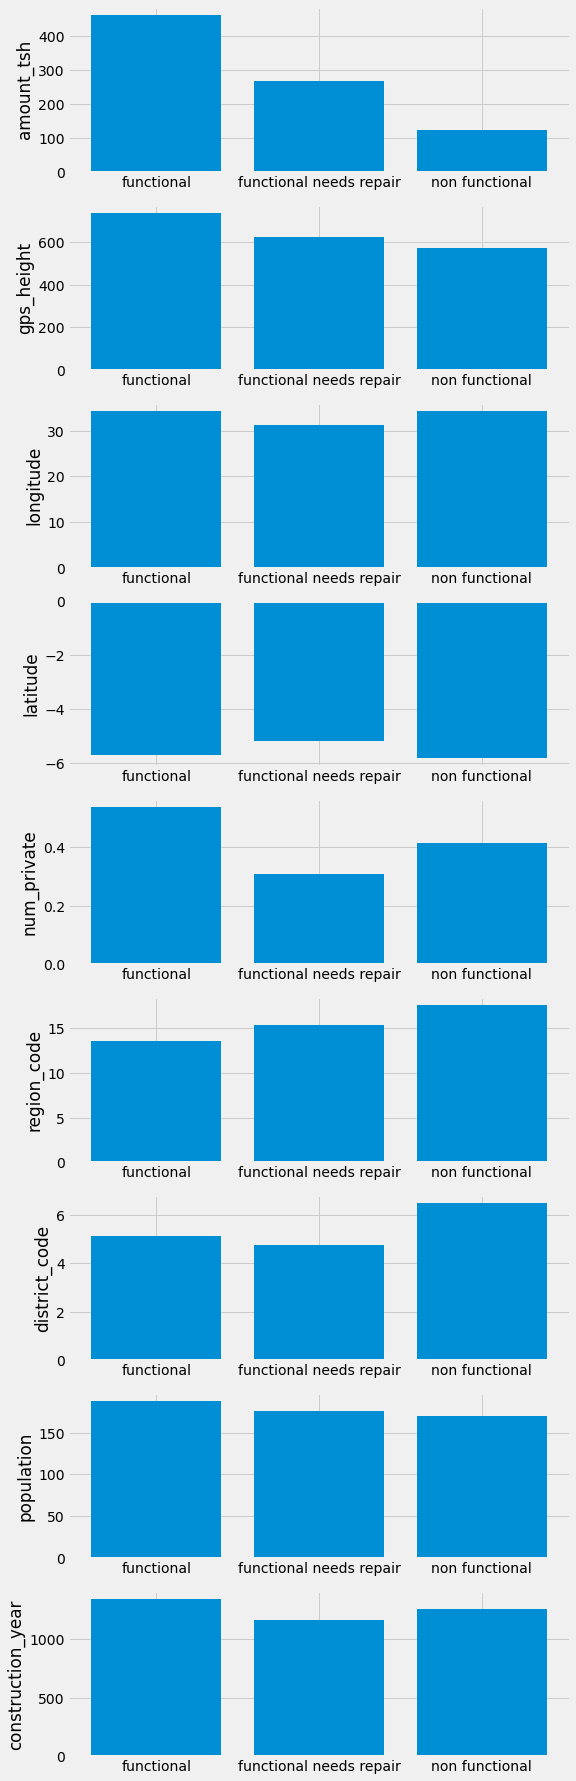

In [40]:
fig,ax = plt.subplots(len(continuous.columns),1,figsize=(8,30)) 
n = 0
for i in continuous:

    f =  df.groupby('status_group').mean()[i].values
    g =  df.groupby('status_group').mean()[i].index
    ax[n].bar(g,f)
    ax[n].set_ylabel(i)
    n+=1

Target has a correlation with the popultaion, the gps hieght, and the water yield

In [41]:
# Create scatter
# fig1, ax = plt.subplots(figsize = (8,8))

# x1 = df['sqft_living']
# y1 = df['price']

# #Build scatterplot
# sns.scatterplot(x1,y1, hue = df['bathrooms'], size = df['bathrooms'], palette = "flare")
# ax.set_xlabel("Square Feet")
# ax.set_ylabel("Sale Price")
# ax.set_title('Sale Price vs Square Feet by # of Bathrooms')
# plt.ticklabel_format(style = 'plain', axis = 'y')
# plt.tight_layout()

# #Save fig
# fig1.savefig('images/sales_per_bathroom.png');

In [42]:
# #Create Barchart

# fig2, ax = plt.subplots(figsize = (8,8))

# x1 = ['Not Waterfront', 'Waterfront']
# y1 = df.groupby('waterfront').mean()['price'].values

# #Build barplot
# sns.barplot(x1,y1)

# ax.set_ylabel("Sale Price")
# ax.set_title('Sale Price of Waterfront vs Non-Waterfront')

# plt.ticklabel_format(style = 'plain', axis = 'y')
# plt.tight_layout()

# #Save Fig
# fig2.savefig('images/sales_per_waterfront.png');

In [43]:
#Define the max value to be used in the heatmap
max_amount = df['amount_tsh'].max()

#Create the basemap using the general lat, long coordinates of King County
hmap = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10, )

#Create the heatmap
hm_wide = HeatMap(list(zip(df['latitude'], df['longitude'], df['amount_tsh'])),
                   min_opacity=0.0001,
                   max_val=max_amount,
                   radius=7, blur=10, 
                   max_zoom=1, 
                 )

#layer the heatmap over the basemap
hmap.add_child(hm_wide)

In [44]:
pop = df['population'].astype('float')

In [45]:
pop

0        109.0
1        280.0
2        250.0
3         58.0
4          0.0
         ...  
59395    125.0
59396     56.0
59397      0.0
59398      0.0
59399    150.0
Name: population, Length: 59400, dtype: float64

In [46]:
#Define the max value to be used in the heatmap
max_amount = pop.max()

#Create the basemap using the general lat, long coordinates of King County
hmap = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10, )

#Create the heatmap
hm_wide = HeatMap(list(zip(df['latitude'], df['longitude'], pop)),
                   min_opacity=0.0001,
                   max_val=max_amount,
                   radius=7, blur=10, 
                   max_zoom=1, 
                 )

#layer the heatmap over the basemap
hmap.add_child(hm_wide)

In [47]:
# # Create Interactive ZipCode Map

# #We need to convert zipcode to a string so it can interact with our json file
# df['district_code'] = df['district_code'].astype('str')

# #Grab the geo json file from the king county website and save it to a folder in the repository
# king_file = "../geojson_files/TZA_adm1_mkoaTZ.geojson"
# with open(king_file, 'r') as f:
#     boundary = json.load(f)

# # create the folium map using general king county lat and long  
# m = folium.Map(location=[47.5480, -121.9836], zoom_start=10, tiles='Stamen Toner')


# # Use the groupby method to get mean value for price
# zipcode_data = df.groupby('district_code').aggregate(np.mean)
# zipcode_data.reset_index(inplace = True)


# # Create choropleth map  
# folium.Choropleth(
#     geo_data=boundary,
#     name='choropleth',
#     data=zipcode_data,
#     columns=['district_code', 'amount_tsh'],
#     key_on='feature.properties.',
#     fill_color='Spectral',
#     fill_opacity=0.6,
#     nan_fill_opacity=0,
#     line_opacity=1,
#     #bins=bins,
#     legend_name='Mean Water Yield'
# ).add_to(m)

# #Create popups for the area code and average price
# for i in range(0,len(zipcode_data)):
#     folium.Marker(
#     location=[zipcode_data.iloc[i]['latitude'], zipcode_data.iloc[i]['longitude']],
#     #icon=icon,
#     radius=float(15000.0),
#     popup="ZipCode: "+ str(zipcode_data.iloc[i]['district_code'])+" Average Price: $"+str(round(int(zipcode_data.iloc[i]['amount_tsh']),0))
#     ).add_to(m)
# m


# Modeling

Table of contents describing the different models used

## Vanilla Models

### Decision Tree

In [44]:
stat_map = {'functional':2,'functional needs repair':1,'non functional':0}
df['status_group'] = df['status_group'].map(stat_map)

In [46]:
# separate features and target
X = df.drop('status_group',axis=1)
y = df['status_group']

In [47]:
X.drop(['wpt_name','subvillage','installer','funder','ward','date_recorded','region_code','recorded_by'],axis=1,inplace=True)

In [48]:
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33,random_state=42)

In [49]:
X_train_cat = X_train.select_dtypes('object')
X_test_cat = X_test.select_dtypes('object')

In [50]:
X_train_con = X_train.select_dtypes('float64')
X_test_con = X_test.select_dtypes('float64')

In [51]:
clmntr = ColumnTransformer([('ohe',OneHotEncoder(sparse=False,handle_unknown='ignore'),list(X_train_cat.columns)),
                            ('ss',StandardScaler(),list(X_train_con.columns) )])

In [52]:
X_train_df = pd.DataFrame(clmntr.fit_transform(X_train))

In [71]:
# Create model and see summary output
from imblearn.pipeline import Pipeline as ImbPipe
from imblearn.over_sampling import SMOTE

pipe_imb = ImbPipe([('trsfm',clmntr),
                ('sm',SMOTE(random_state=42)),
                ('dtree',DecisionTreeClassifier(random_state=42))])#

pipe = Pipeline([('trsfm',clmntr),
                ('dtree',DecisionTreeClassifier(random_state=42))])#

pipe.fit(X_train,y_train)
pipe_imb.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['basin', 'region', 'lga',
                                                   'recorded_by',
                                                   'scheme_management',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                                                   'management_group',
                                                   'payment', 'payment_type',
                                                   'water_quality',
                              

In [63]:
np.mean(cross_val_score(estimator=pipe,X=X_train_cat,y=y_train,cv=5))

nan

In [73]:
pipe.score(X_train,y_train),pipe_imb.score(X_train,y_train)

(0.995050002512689, 0.9934670083923816)

In [74]:
pipe.score(X_test,y_test),pipe_imb.score(X_test,y_test)

(0.751147842056933, 0.7392612998673604)

In [75]:
y_hat_train = pipe_imb.predict(X_train)
y_hat_test = pipe_imb.predict(X_test)

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15366
           1       0.93      0.99      0.96      2892
           2       1.00      0.99      0.99     21540

    accuracy                           0.99     39798
   macro avg       0.98      0.99      0.98     39798
weighted avg       0.99      0.99      0.99     39798

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      7458
           1       0.33      0.47      0.39      1425
           2       0.81      0.76      0.79     10719

    accuracy                           0.74     19602
   macro avg       0.63      0.66      0.64     19602
weighted avg       0.75      0.74      0.75     19602



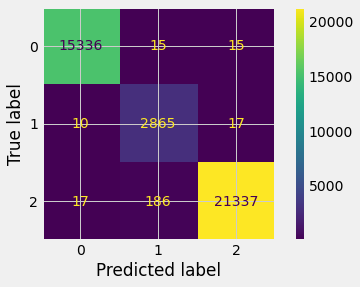

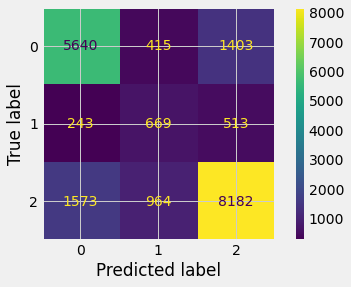

In [76]:
print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

plot_confusion_matrix(pipe_imb,X_train,y_train)
plot_confusion_matrix(pipe_imb,X_test,y_test)

### Logistic Regression

In [77]:
pipe_lr_imb = ImbPipe([('trsfm',clmntr),
                   ('sm',SMOTE(random_state=42)),
                   ('lr',LogisticRegression(random_state=42))])#
pipe_lr_imb.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['basin', 'region', 'lga',
                                                   'recorded_by',
                                                   'scheme_management',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                                                   'management_group',
                                                   'payment', 'payment_type',
                                                   'water_quality',
                              

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       0.77      0.65      0.70     15366
           1       0.22      0.71      0.33      2892
           2       0.80      0.64      0.71     21540

    accuracy                           0.65     39798
   macro avg       0.60      0.67      0.58     39798
weighted avg       0.75      0.65      0.68     39798

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.76      0.65      0.70      7458
           1       0.21      0.71      0.32      1425
           2       0.80      0.63      0.71     10719

    accuracy                           0.64     19602
   macro avg       0.59      0.66      0.58     19602
weighted avg       0.74      0.64      0.68     19602



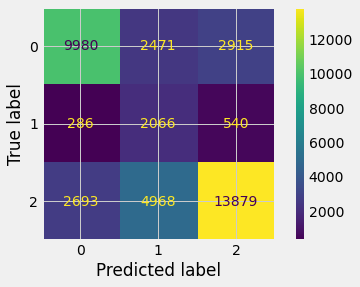

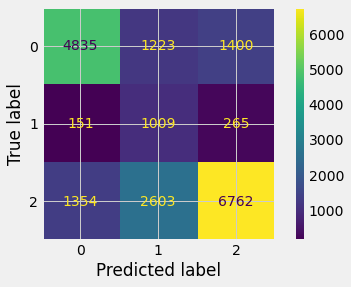

In [80]:
y_hat_train = pipe_lr_imb.predict(X_train)
y_hat_test = pipe_lr_imb.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

plot_confusion_matrix(pipe_lr_imb,X_train,y_train)
plot_confusion_matrix(pipe_lr_imb,X_test,y_test)

### KNN Classifier

In [81]:
pipe_knn = Pipeline([('trsfm',clmntr),('lr',KNeighborsClassifier())])#
pipe_knn.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['basin', 'region', 'lga',
                                                   'recorded_by',
                                                   'scheme_management',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                                                   'management_group',
                                                   'payment', 'payment_type',
                                                   'water_quality',
                              

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     15366
           1       0.64      0.46      0.54      2892
           2       0.85      0.90      0.87     21540

    accuracy                           0.84     39798
   macro avg       0.78      0.73      0.75     39798
weighted avg       0.84      0.84      0.84     39798

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.77      0.76      0.77      7458
           1       0.45      0.34      0.39      1425
           2       0.80      0.84      0.82     10719

    accuracy                           0.77     19602
   macro avg       0.68      0.65      0.66     19602
weighted avg       0.76      0.77      0.77     19602



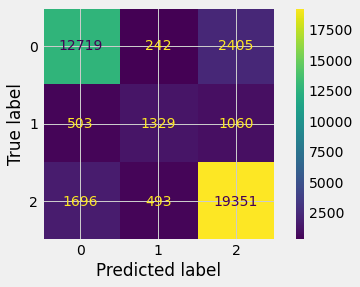

In [82]:
y_hat_train = pipe_knn.predict(X_train)
y_hat_test = pipe_knn.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

plot_confusion_matrix(pipe_knn,X_train,y_train)

In [2]:
sm = SMOTE()

NameError: name 'SMOTE' is not defined

In [87]:
pipe_bag = ImbPipe([('trsfm',clmntr),
                     ('sm',SMOTE(random_state=42)),
                     ('lr',BaggingClassifier(n_estimators=100,verbose=1,random_state=42))])#
pipe_bag.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min finished


Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['basin', 'region', 'lga',
                                                   'recorded_by',
                                                   'scheme_management',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                                                   'management_group',
                                                   'payment', 'payment_type',
                                                   'water_quality',
                              

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s finished
Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15366
           1       0.94      0.99      0.96      2892
           2       1.00      0.99      0.99     21540

    accuracy                           0.99     39798
   macro avg       0.98      0.99      0.99     39798
weighted avg       0.99      0.99      0.99     39798

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      7458
           1       0.37      0.50      0.42      1425
           2       0.82      0.80      0.81 

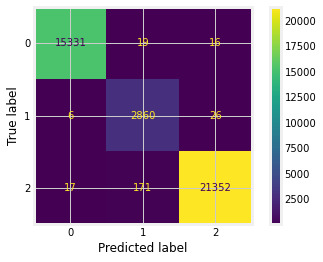

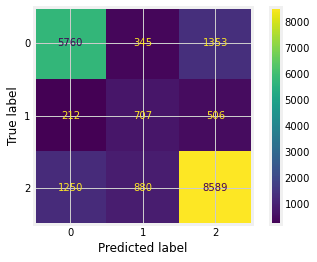

In [88]:
y_hat_train = pipe_bag.predict(X_train)
y_hat_test = pipe_bag.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

plot_confusion_matrix(pipe_bag,X_train,y_train)
plot_confusion_matrix(pipe_bag,X_test,y_test)

In [89]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  int64  
 2   longitude              59400 non-null  float64
 3   latitude               59400 non-null  float64
 4   num_private            59400 non-null  int64  
 5   basin                  59400 non-null  object 
 6   region                 59400 non-null  object 
 7   region_code            59400 non-null  int64  
 8   district_code          59400 non-null  int64  
 9   lga                    59400 non-null  object 
 10  population             59400 non-null  int64  
 11  public_meeting         59400 non-null  bool   
 12  recorded_by            59400 non-null  object 
 13  scheme_management      59400 non-null  object 
 14  permit                 59400 non-null  bool   
 15  co

In [95]:
clmntr = ColumnTransformer([('ohe',OneHotEncoder(sparse=False,handle_unknown='ignore'),list(X_train_cat.columns)),
                            ('ss',StandardScaler(),list(X_train_con.columns) )])

In [96]:
pipe_knn_short = Pipeline([('trsfm',clmntr),
                           ('sm',SMOTE(random_state=42)),
                           ('lr',KNeighborsClassifier())])#
pipe_knn_short.fit(X_train,y_train)

Pipeline(steps=[('trsfm',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['basin', 'region', 'lga',
                                                   'scheme_management',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'management',
                                                   'management_group',
                                                   'payment', 'payment_type',
                                                   'water_quality',
                                                   'quality_group', 'quantity',
                

Evaluation Metrics: Train Data

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     15366
           1       0.55      0.32      0.41      2892
           2       0.81      0.87      0.84     21540

    accuracy                           0.80     39798
   macro avg       0.72      0.66      0.68     39798
weighted avg       0.79      0.80      0.79     39798

---------------------------------------------

Evaluation Metrics: Test Data

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      7458
           1       0.46      0.28      0.35      1425
           2       0.79      0.83      0.81     10719

    accuracy                           0.76     19602
   macro avg       0.67      0.62      0.64     19602
weighted avg       0.75      0.76      0.75     19602



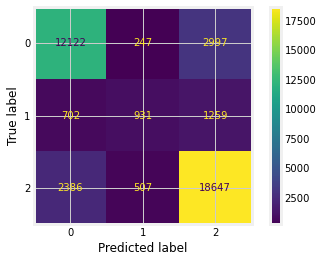

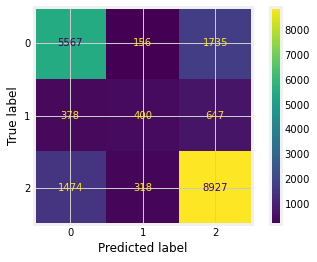

In [97]:
y_hat_train = pipe_knn_short.predict(X_train)
y_hat_test = pipe_knn_short.predict(X_test)

print('Evaluation Metrics: Train Data\n')
print(classification_report(y_train,y_hat_train))
print('---------------------------------------------\n')
print('Evaluation Metrics: Test Data\n')
print(classification_report(y_test,y_hat_test))

plot_confusion_matrix(pipe_knn_short,X_train,y_train)
plot_confusion_matrix(pipe_knn_short,X_test,y_test)

In [ ]:
rom sklearn.model_selection import GridSearchCV

param_grid = {
    'knn__n_neighbors': [5, 6, 7, 8, 9, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__leaf_size': [15, 20, 25, 30, 25, 40, 45],
    'knn__p': [1, 2]
}

search = GridSearchCV(pipe_knn, param_grid, n_jobs=-1)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'lr__tol': [1e-4, 1e-2, 1]
    'lr__C': [1.0, 1.3, 1.5]
    'lr__solver': ['newton-cg', 'liblinear', 'sag', 'saga']
    'lr__multi_class': ['auto', 'ovr', 'multinomial']

}

search = GridSearchCV(pipe_lr, param_grid, n_jobs=2)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'lr__tol': [1e-4, 1e-2, 1]
    'lr__C': [1.0, 1.3, 1.5]
    'lr__solver': ['newton-cg', 'liblinear', 'sag', 'saga']
    'lr__multi_class': ['auto', 'ovr', 'multinomial']

}

search = GridSearchCV(pipe_lr, param_grid, n_jobs=2)
search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


# Conclusions

**1. Best to sell homes from the northern side of King County, and waterfront homes.** Our analysis shows that as you move north in King County, homes tend to sell for a higher price. The prices also increase as you get closer to the big cities and closer to the waterfront.

**2. Recommend clients to renovate to increase property value.** Our analysis shows that renovated homes sell for a higher price than those homes not renovated. Our models show that renovating to increase square footage increases the sale price and consider adding extra bathrooms in the renovation as that also increases the price. Also consider improving the view of the home when renovating.

**3. Consider selling in the late spring, early summer.** The most homes wre sold in May for both years of our data. Homes tend to increase in sales during the spring and tend decrease slightly in the winter months.  

# Next Steps

Further analyses could provide even more insight into how you will advise your clients to buy or sell thier home. 

**Better idea of how data was taken** We would look into how the population data and the water yeild data were taken and at what times they were taken. It could very well be that the Ministry of Water are aggregating this data from another source.

